# Data / Problem Description

Link to GitHub Repo: https://github.com/mckomisarek878/spotify-song-clustering

Link to Data: https://www.kaggle.com/datasets/geomack/spotifyclassification

**Problem**

Music today is more genre bending than ever and people often listen to many different genres. Humans have a very specific view of what is considered a genre (eg. Pop, Rock, Rap). Considering many people genre mix and many songs can convey similar feelings or scratch the same itch as songs from other genres, suggesting songs to users based on their most listened genre is a very naiive approach.

Unsupervised machine learning algorithms like clustering can group songs that are similar to each other and create its own 'genres' or clustering of similar songs oblivious to what genres they are.

Finding unknown clusters of songs serves many benefits. The most obvious being that platforms like spotify can more correctly identify songs to suggest to their users. This will lead to more engagement on their platform and more income for Spotify.

We will attempt to use clustering algorithms and other unsupervised methods to cluster similar songs and make hypotheses on our results.

**Data / Shape**

Our data comes from a Kaggle dataset. The data lies in a CSV file and contains 2,017 songs with 17 columns. The columns contain features ranging from categorical to numerical features such as tempo, duration, and the artist of the song. One of these columns is unnamed and seems to follow the indexing of the CSV file. This means that are usable data is 2017 songs with 16 feature columns.

Most of the features are self explanatory but those that I thought were less obvious are the following:

- Mode: Major or Minor key.
- Valence: Positive or Negative emotion conveyed by the song.

**Importing Libraries**

There will be many more libraries used in this project but before we write any code we will import the following libraries to start:

- pandas (data processing)
- numpy (linear algebra)
- os (observing file paths)

In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/spotifyclassification/data.csv


**Loading CSV into DataFrame / Visualization**

A pandas data frame will make it very easy to observe and edit data as if it is directly coming from the CSV file. We will load our data into a pandas dataframe and observe the first few rows as well as the data types and number of entries.

This project was done in a Kaggle notebook. If a user is running this on their own machine, they will need to download the CSV from the link above and edit the data path.

In [29]:
data_path = '/kaggle/input/spotifyclassification/data.csv'
df = pd.read_csv(data_path)

df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2017 non-null   int64  
 1   acousticness      2017 non-null   float64
 2   danceability      2017 non-null   float64
 3   duration_ms       2017 non-null   int64  
 4   energy            2017 non-null   float64
 5   instrumentalness  2017 non-null   float64
 6   key               2017 non-null   int64  
 7   liveness          2017 non-null   float64
 8   loudness          2017 non-null   float64
 9   mode              2017 non-null   int64  
 10  speechiness       2017 non-null   float64
 11  tempo             2017 non-null   float64
 12  time_signature    2017 non-null   float64
 13  valence           2017 non-null   float64
 14  target            2017 non-null   int64  
 15  song_title        2017 non-null   object 
 16  artist            2017 non-null   object 


,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


**Dropping Unnecessary Columns**

The unnamed column gives no learnable information for the song that it is tied to so we will not need it. We will also drop the artist and song name as we would like to use this model to show users songs that they likely would not have found on their own. If they like Future, we dont want the model to biasedly cluster Future songs together. We will also drop the 'Target' column as it only takes on two values and it is unclear from the dataset description what it represents.

We will keep the original dataframe (df) as is for future use such as comparing titles of similar songs. We will save the cleaned data frame to train_df.

In [30]:
train_df = df.drop(columns=['Unnamed: 0', 'target', 'song_title', 'artist'])
train_df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904


**Check NA Values**

Some training examples may not have an entry for every column. We need to check if that is the case incase we need to convert them to numeric values

In [31]:
rows_with_null = train_df.isna().any(axis=1).sum()
print(f'Rows with null values: {rows_with_null}')


Rows with null values: 0


There are no rows with missing entries, so we will not have to worry about this

**Visualization**

In [32]:
import matplotlib.pyplot as plt

**Converting to NumPy**

DataFrame objects have lots of extra information about the data. Although some machine learning libraries will accept a dataframe, NumPy provides many functions that will make our EDA process easier.

In [33]:
X = np.asarray(train_df).astype(np.float32)
X.shape

(2017, 13)

**Standardization**

Because our data takes on such a wide range of values, machine learning algorithms will give bias toward features with a larger range, especially distance based algorithms such as clustering. So we will have to Standardize our data because of this and for PCA.

In [34]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

**PCA**

There is a chance that not all of our features give us useful information about the data. We will conduct Principal Component Analysis to see if we can compress our features into a smaller subset of features that will explain a majority of the variance of the dataset. If we can, this will make visualization easier.

PCA will compress our features into a specified number (k) of prinicpal components. We will fun PCA from k = 1 to k = number of features to observe how many principal components we need to explain all of the necessary variance of our data.

In [35]:
from sklearn.decomposition import PCA
explained_variances = []

for k in range(1, X.shape[1] + 1):
    pca = PCA(n_components=k)
    pca.fit(X_std)

    # sum explained variance up to k components

    explained_variances.append((k, pca.explained_variance_ratio_.sum()))
print(explained_variances)

[(1, 0.2189104), (2, 0.33624986), (3, 0.43736455), (4, 0.5238826), (5, 0.603662), (6, 0.6783437), (7, 0.7472672), (8, 0.80829674), (9, 0.86603385), (10, 0.91650444), (11, 0.9576692), (12, 0.98719084), (13, 0.99999994)]


**PCA Results**
Our results for the explained variance up to k principal components show that the variances is incrementally explained by each feature. This means that our data set is pretty clean and there would be little benefit from using training data that was transformed by PCA for clustering as only one principal component is shown to provide minimal explaination to the variance of the data.

# Analysis (Model Building and Training)

**Model Family: Clustering**

Given that our data is almost purely numeric, distance based algorithms can do a good job of seperating different training examples based on their features. Clustering was made for this exact type of problem: Classifying songs into unknown groups (clusters) to gauge similarity. That way we can reccomend songs to users that are in the same cluster as songs they already enjoy.

**Model Selection: K Means**

We will use the KMeans clustering algorithm. This model was chosen for several reasons over heirarchical clustering:

- Heirarchical Clustering is more sensitive to outliers.
- KMeans is more efficient.
- KMeans is easier to interpret because we can observe cluster centers (centroids) as the baseline for a certain class.
- Heirarchical Clustering has many different hyper-parameters that can yield vastly different results.
____________________________________________________________________________________________________

**Hyper-Parameter Tuning**

KMeans requires that we specify the number of clusters to find before training the model. 

**Elbow Method**
The identify an appropriate number of clusters we will visualize an elbow plot. This is done by training a new KMeans model several times on our data with a different number of 'n_clusters'. Then we will use a metric called Sum of Squared Errors (SSE) to measure how tightly packed our clusters are. We will plot this metric over each number of n_clusters. Tightly packed clusters will give a lower SSE score show represent more well defined classes. When the slope of the plot flattens out (elbows) we can observe this as a good number of n_clusters to use.

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

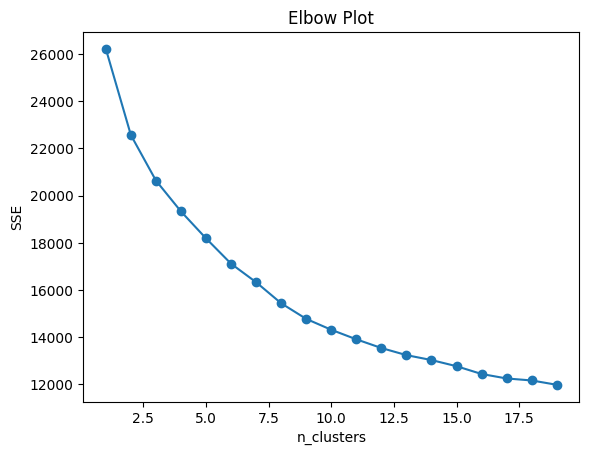

In [36]:
from sklearn.cluster import KMeans

sse = []
K = range(1, 20)
for k in K:
    km = KMeans(n_clusters=k, random_state=1).fit(X_std)
    sse.append(km.inertia_)

plt.plot(K, sse, marker='o')
plt.xlabel('n_clusters')
plt.ylabel('SSE')
plt.title('Elbow Plot')
plt.show()

**SSE Takeaways** 

Since we cannot observe an 'elbow' in our Elbow Plot, this means that clusters dont have a clear seperation and tend to overlap. This was not unexpected but we will have to use another approach to selecting the number of n_clusters for our model.

**Silhouette Score**

This metric measures how well seperated clusters are. The Silhouette Score is calculate like this:

a = average distance to points in the same cluster
b = average distance to points in the nearest other cluster

silhouette = (b - a) / max(a, b)

We will plot silhouette scores of each model with a different number of n_clusters to visualize the best number of k. Higher Silhouette scores are better and represent the most optimal selection of n_clusters.

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

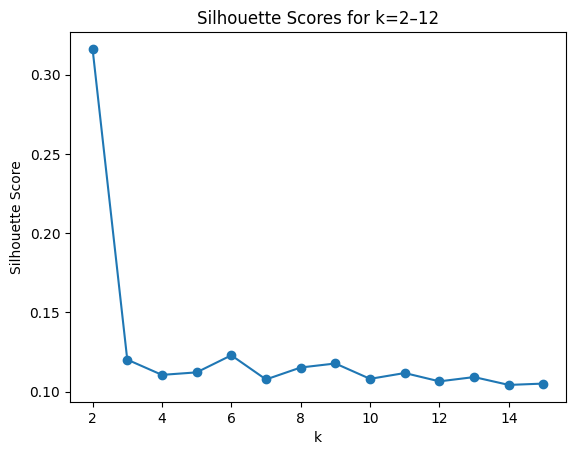

In [37]:
from sklearn.metrics import silhouette_score

sil_scores = []
for k in range(2, 16):
    km = KMeans(n_clusters=k, random_state=1).fit(X_std)
    sil_scores.append(silhouette_score(X_std, km.labels_))

plt.plot(range(2,16), sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for k=2–12")
plt.show()



**Silhouette Score Results**

Although the silhouette scores are highest at 2 clusters, seperating all these songs into two groups is not very beneficial for our project and that is just the result from overlapping clusters.

We can however derive meaning from grouping the songs into 6 different clusters, and 6 clusters yields our next highest sihouette score.

**K Selection**

Based on our plots for SSE and Silhouette Scores for different numbers of K, the optimal K seems to be 6 clusters and that is what we will choose to use.

_______________________________________________________________________

**Final Model Training**

Training KMeans to cluster our dataset into 6 different clusters.


In [38]:
final_model = KMeans(n_clusters=6, random_state=1)
final_model.fit(X_std)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=6, random_state=1)

# Results

KMeans inherently uses centroids or cluster centers to identify clusters. This is beneficial because we can look at the features of those centroids to make observations on the different clusters our model found. 

We will make a  color-coded bar plot to visualize what features our clusters exhibit and attempt to put labels on them.

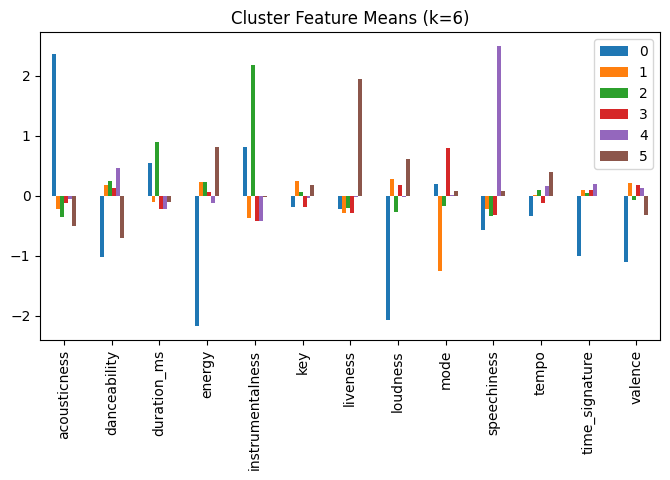

In [39]:
cluster_centers = pd.DataFrame(final_model.cluster_centers_, columns=train_df.columns)
cluster_centers.T.plot(kind='bar', figsize=(8,4))
plt.title("Cluster Feature Means (k=6)")
plt.show()

**Giving Clusters Names**

From the plot above we can name our clusters by the features that they exhibit. The names I chose to give them are the following.

Cluster 0: Acoustic / Chill Ballads
- Extreme Acousticness, low energy, low loudness, low valence

Cluster 1: Upbeat Dance Pop (Minor Key)
- Above average dancability, energy, and loudness, minor Keys (low mode), highest valence.

Cluster 2: Ambient / Instrumental
- longest duration, extreme instrumentalness, low speechiness, low acousticness.

Cluster 3: Bright Major-Key Pop
- High mode (major keys), decent danceability, decent valence, low speechiness, low acousticness.

Cluster 4: Rap / Spoken-Word Energy
- Extreme/highest speechiness, decent tempo, high time signature, highest danceability

Cluster 5: Live / Raw Performances (Low Energy)
- Low acousticness, low danceability, Extreme/highest liveness, low valence

**Labeling Songs**

Now we will label the data from our original data frame. We will assign the name we gave to each cluster so that we can observe what songs are similar to each other and why.

In [40]:
#extract labels from our model
labels = final_model.labels_
# cloning original dataframe
labeled_songs = df.copy()
# adding column for the labels
labeled_songs["cluster"] = labels

# mapping cluster labels to cluster names
label_to_name = {
    0: 'Acoustic / Chill Ballads',
    1: 'Upbeat Dance Pop (Minor Key)',
    2: 'Ambient / Instrumental',
    3: 'Bright Major-Key Pop',
    4: 'Rap / Spoken-Word Energy',
    5: 'Live / Raw Performances (Low Energy)'
}

# adding human readable column for labels using our map
labeled_songs["cluster_name"] = labeled_songs["cluster"].map(label_to_name)

# show first few rows
labeled_songs[["song_title", "artist", "cluster_name"]].head(15)


,song_title,artist,cluster_name
0,Mask Off,Future,Rap / Spoken-Word Energy
1,Redbone,Childish Gambino,Bright Major-Key Pop
2,Xanny Family,Future,Rap / Spoken-Word Energy
3,Master Of None,Beach House,Acoustic / Chill Ballads
4,Parallel Lines,Junior Boys,Ambient / Instrumental
5,Sneakin’,Drake,Bright Major-Key Pop
6,Childs Play,Drake,Bright Major-Key Pop
7,Gyöngyhajú lány,Omega,Ambient / Instrumental
8,I've Seen Footage,Death Grips,Rap / Spoken-Word Energy
9,Digital Animal,Honey Claws,Rap / Spoken-Word Energy


**Analysis of Results**

The clusters identified by KMeans showed substantial overlap, which is expected given that the Spotify audio features represent continuous musical dimensions rather than discrete categories. Music does not naturally fall into strict partitions, so the absence of clean boundaries is not a failure of the model but rather a reflection of the underlying data structure.

Despite this overlap, we were still able to determine a practical number of clusters using the silhouette score. While no strong peak indicated a “true” number of clusters, k = 6 provided the second-highest silhouette score (with k = 2 producing an uninformative binary split). Importantly, the clusters formed at k = 6 were meaningful, interpretable, and musically coherent. For example, the model grouped multiple Future songs together in the same cluster, as well as other hip-hop artists with similar production styles, indicating that the clustering captured genuine structure in the data.

These clusters also allowed us to assign human-readable labels such as “Rap / Spoken-Word Energy,” “Ambient / Instrumental,” and “Acoustic / Chill Ballads.” Even in cases where artists differ dramatically in genre or popularity, the model was able to identify underlying similarities in energy, acousticness, mode, and other audio features. For instance, a listener might not intuitively recommend a psychedelic Turkish rock artist like Erkin Koray to a Lil Yachty fan, yet the model places both under “Bright Major-Key Pop” because their songs share similar tonal and structural attributes. This suggests that clustering can reveal non-obvious musical relationships that human intuition alone might miss.

Overall, the model demonstrates potential for real-world applications such as playlist generation, content-based music recommendation, and music discovery tools that operate independently of genre labels. Traditional genres can be vague, inconsistent, or culturally biased, whereas feature-based clustering presents a more objective approach to grouping music by sound rather than metadata.

Still, limitations remain. The overlapping clusters and low-to-moderate silhouette scores indicate that Spotify’s audio features do not fully capture the richness of musical variety. Lyrics, production style, emotional arc, cultural context, and vocal characteristics—none of which appear in this dataset—likely contribute heavily to perceived musical similarity. Future improvements could incorporate lyrics embeddings or instrumental feature extraction.

# Conclusion / Discussion

In this project, we explored whether unsupervised learning—specifically KMeans clustering could uncover meaningful structure in a dataset of Spotify audio features and group songs according to their underlying musical characteristics rather than their genre labels. Although the dataset did not contain clear natural separations and the songs existed on continuous feature spectra, KMeans was still able to produce clusters that were musically interpretable and practically useful. This highlights an important takeaway: perfectly separated clusters are not necessary for unsupervised learning to generate actionable insight.

Several modeling decisions contributed positively to our results.
Standardizing the data was essential, as the audio features spanned very different ranges and KMeans is heavily influenced by scale. PCA, on the other hand, did not improve performance or interpretability; the explained variance plot showed that no small subset of principal components captured a meaningful fraction of the overall variance. This indicated that PCA compression would only remove information rather than reveal clearer cluster structure. The silhouette score ultimately served as our most useful model selection tool, allowing us to justify k = 6 as a balanced choice that avoided trivial two-cluster splits while still producing coherent, interpretable groups.

The resulting clusters revealed intuitive and sometimes surprising relationships among songs. For example, multiple hip-hop artists landed together in the “Rap / Spoken-Word Energy” cluster based on their high speechiness and rhythmic structure, while acoustic singer-songwriter tracks formed a distinct “Chill Ballads” group. More interestingly, the model identified cross-genre similarities that human intuition might overlook—such as placing a Turkish rock song and a modern trap song into the same “Bright Major-Key Pop” cluster due to their shared tonal and structural features. These examples demonstrate how feature-driven clustering can expose underlying musical patterns that traditional genre labels fail to capture.

However, the project also highlighted several limitations. The relatively low silhouette scores and the smooth SSE curve both reflected the fact that music is not discretely organized in feature space; songs blend into one another along continuous stylistic dimensions. More importantly, the dataset captures only a portion of what defines a song: it omits lyrics, timbre, production elements, vocal qualities, and cultural context—all of which strongly influence musical similarity. Incorporating richer data sources such as audio embeddings  or natural language embeddings of lyrics could significantly improve cluster separation and lead to more nuanced recommendations.

Overall, this project demonstrated that unsupervised learning can provide a valuable alternative to genre-based recommendation systems. Even with overlapping clusters and limited features, KMeans enabled the discovery of meaningful musical groupings and offered insights into how songs relate beyond traditional genre boundaries. With more sophisticated feature engineering and richer data, future versions of this model could form the foundation of a personalized, content-based music recommendation engine that aligns more closely with how listeners actually perceive and enjoy music.